# Algoritmos Genéticos

**Autores:**

- *Jordi Hamberg*
- *Adriana Gonzalez*
- *Héctor Sancho*

## TSP

Para los ejemplos utilizaremos el problema del viajante de comercio (TSP)

## Definicion de funciones bascicas

Definimos funciones para trabajar con distancias ya que la funcion de fitness que utilizaremos es la distancia total del camino.

In [14]:
import random
from madrid import *
import matplotlib.pyplot as plt
import numpy as np

def dist (x: tuple[int], y: tuple[int]) -> float:
	""""Dados dos puntos, devuelve la distancia euclidea entre ellos"""

	return ( ( (x[0]-y[0])**2 + (x[1]-y[1])**2 ) ** 0.5 ) * 111.1 # km por grado

def globaldist (cities_cords: list[tuple[int]]) -> float:
	""""Dada una lista de ciudades (cromosoma como indices), devuelve la distancia total del
	camino que las une en el orden dado"""
	acum = 0.0
	for i in range(len(cities_cords)):
		acum += dist(cities_cords[i-1],cities_cords[i])
	return acum


def nearest (c: tuple[int], l: list[tuple[int]]) -> tuple[int]:
	""""Dado un punto y una lista de puntos, devuelve el punto de la lista mas cercano al punto dado"""
	res = l[0]
	d = dist(c,l[0])
	for e in l[1:]:
		newd = dist(c,e)
		if newd < d:
			res = e
			d = newd
	return res

definimos una funcion para dibujar un camino sobre el mapa.

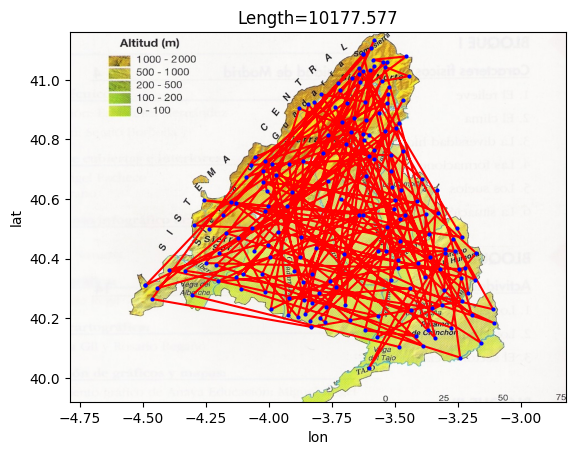

In [15]:
def draw (solution):
    minx, maxx = -4.79, -2.82
    miny, maxy = 39.92, 41.16
    margx = 0.05
    margy = 0.1

    plt.ion()
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_xlabel('lon')
    axes.set_ylabel('lat')
    axes.set_xlim(minx, maxx)
    axes.set_ylim(miny, maxy)
    img = plt.imread("media/madrid.jpg")
    plt.imshow(img, extent=[minx-margx,maxx+margx,miny-margy,maxy+margy], aspect='auto')

    bucle = solution + [solution[0]] # añade al final la vuelta a la primera
    c = np.array(bucle)
    x = c[:,1]
    y = c[:,0]

    axes.plot(x, y,'r')
    axes.plot(x, y,'bo',markersize=2)
    
    s = 'Length=%5.3f' % globaldist(bucle)
    plt.title(s)

draw(cities)

## Implementacion de AG:

implementamos un AG generico como clase abstracta de la cual heredaran las clases para definir un algoritmo genetico concreto.

In [16]:
from abc import ABC, abstractmethod
import random

class AG(ABC):
    def __init__ (self, alphabet, fitness_func, L, pcross, pmut, T):
        # inicializa atributos de clase (puedes añadir más cosas)
        self.alphabet = alphabet # alfabeto a utilizar
        self.finess_func = fitness_func # función de fitness
        self.L = L # en permutación debe ser igual a len(alphabet)
        self.pcross = pcross # probabilidad de cruce
        self.pmut = pmut # probabilidad de mutación
        self.T = T # parámetro T para selección por torneo

    def sort_pop (self, pop): # ordena población por firness

        fitnes_list = list(map(self.finess_func, pop))
        pop_to_fit = list(zip(pop, fitnes_list))
        pop_to_fit = sorted(pop_to_fit, key=lambda p: p[1], reverse=True)
        pop_ordenada, fitness_ordenada = zip(*pop_to_fit)
        return list(fitness_ordenada), list(pop_ordenada)


    def select (self, pop, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
        selected_pop = random.choices(pop, k=T)
        # La seleccion de los participantes en el torneo se hace con reemplazamiento.
        return max(selected_pop, key=self.finess_func)
    
    @abstractmethod
    def crossover (self, ind1, ind2):
        pass

    @abstractmethod
    def mutate (self, ind:list[int]):
        pass

    def evolve (self, pop, ngen=100, trace=0, elitism=False, T=10):
        N = len(pop)

        for i in range(ngen): # para cada generación
            newpop = []
            f, pop = self.sort_pop(pop) # ordena por fitness (mayor fitness = mejor)
            best = pop[0]
            bestf = f[0]
            if elitism: # mantiene los dos mejores
                newpop.append(pop[0].copy())
                newpop.append(pop[1].copy())
            while len(newpop) < N:
                i1 = self.select(pop, T)
                i2 = self.select(pop, T)
                i1, i2 = self.crossover(i1, i2)
                i1 = self.mutate(i1)
                i2 = self.mutate(i2)
                newpop.append(i1)
                if len(newpop) < N:
                    newpop.append(i2)
            pop = newpop

            if trace != 0 and i % trace == 0:
                dist_best = 1 / bestf - 1  # convertimos fitness -> distancia real
                print(f"GEN {i+1:4d}: distancia mejor -> {dist_best:.2f} km  (fitness={bestf:.6f})")

        f, pop = self.sort_pop(pop)
        best_dist = 1 / f[0] - 1
        print(f"\nDistancia óptima: {best_dist} km  (fitness={f[0]})")
        return pop



class AG_non_implemented(AG):
    """Esta clase es igual a la anterior pero python no deja instanciar una abstract class
    y queremos hacer pruebas antes de hacer una implementacion completa"""
    def crossover (self, ind1, ind2):
        pass
    def mutate (self, ind:list[int]):
        pass


### Test basico

In [17]:
basic_ag = AG_non_implemented(alphabet=range(10), fitness_func=lambda x: x, L=10, pcross=0.5, pmut=0.1, T=3)
pop = np.random.randint(0, 10, 20).tolist()


print("Devolvemos correctamente la poblacion y el fitness ordenado: ", end="")
print(basic_ag.sort_pop(pop))
print("Hamos varios tournements de T=5 y observamos que salen buenos individuos: ", end="")
print([basic_ag.select(pop, T=5) for _ in range(10)])


Devolvemos correctamente la poblacion y el fitness ordenado: ([9, 8, 8, 7, 7, 7, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 2, 2, 1], [9, 8, 8, 7, 7, 7, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 2, 2, 1])
Hamos varios tournements de T=5 y observamos que salen buenos individuos: [5, 4, 7, 8, 7, 7, 8, 7, 8, 7]


### Implementacion para permutaciones de conjuntos discretos.

In [18]:
class AG_perm (AG):
    def __init__(self, alphabet, fitness_func, L, pcross, pmut, T):
        super().__init__(alphabet, fitness_func, L, pcross, pmut, T)

    def create (self, N=100):
        # Creamos cromosomas identicos al alfabeto
        pop =  [self.alphabet.copy() for _ in range(N)]
        for p in pop:
            random.shuffle(p)
        return pop
        
        

    def crossover (self, ind1, ind2): # order crossover (OX1)
        if random.random() > self.pcross:
            return ind1.copy(), ind2.copy()

        def gen_child(ind1, ind2):
            dif_set = set(ind2) - set(ind1[a:b+1]) # Conjunto de genes del padre 2 destinados al descendiente
            dif_list_ind_2 = [gen for gen in ind2 if gen in dif_set] # Usamos es set lispara generar la lista (Respetando orden)
            child = dif_list_ind_2[:a] + ind1[a:b+1] + dif_list_ind_2[a:] # Combinacion de los genes
            return child

        L = len(ind1)
        a, b = sorted(random.sample(range(L), 2))

        child1 = gen_child(ind1, ind2)
        child2 = gen_child(ind2, ind1)

        return child1, child2
        

    def mutate (self, ind:list[int]): # la mutación consistirá en intercambiar elementos
        out = ind.copy()
        if random.random() < self.pmut:
            a, b = random.sample(range(self.L), 2)
            out[a], out[b] = out[b], out[a]
        return out



In [19]:
basic_ag_perm = AG_perm(
    alphabet=list(range(10)),
    fitness_func=lambda x:x,
    L = 10,
    pcross =1,
    pmut=1,
    T=3
)

print("Generamos 5 individuos y comprobamos que los cromosomas son permutaciones aleatorias.")
print(basic_ag_perm.create(N=5))
print("Generamos un crossover y vemos que se generan 2 individuos con cruces de sus cromosomas")
print(basic_ag_perm.crossover(ind1=["#"]*10, ind2=[" "]*10))
print("Vemos que se ha producido un operador swap (La pmut fue fijada a 1 por el ejemplo).")
print(basic_ag_perm.mutate((list(range(10)))))

Generamos 5 individuos y comprobamos que los cromosomas son permutaciones aleatorias.
[[6, 2, 9, 4, 8, 1, 3, 7, 5, 0], [1, 3, 2, 7, 4, 9, 5, 0, 8, 6], [5, 2, 1, 6, 0, 4, 9, 3, 8, 7], [6, 3, 8, 5, 4, 0, 1, 9, 2, 7], [3, 7, 0, 8, 4, 6, 2, 5, 9, 1]]
Generamos un crossover y vemos que se generan 2 individuos con cruces de sus cromosomas
([' ', ' ', '#', '#', '#', '#', '#', '#', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '], ['#', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#', '#', '#', '#', '#', '#', '#', '#'])
Vemos que se ha producido un operador swap (La pmut fue fijada a 1 por el ejemplo).
[9, 1, 2, 3, 4, 5, 6, 7, 8, 0]


### Funcion fitness para fitness:

vamos a cambiar la funcion fitness del problema para que la entrada sea una lista de INDICES de modo que los cromosomas sean INDICES y con coordenadas (Ya que vamos a tener muchas instancias y se notara la perdida en rendimiento).

In [20]:
def cities_fitness(idx_list):
    cords_list = list(map(lambda idx: cities[idx], idx_list))
    return 1 / (globaldist(cords_list) + 1)

In [21]:
ag_cities_solver = AG_perm(list(range(len(cities))), cities_fitness, len(cities), 0.8, 0.2, 40)

In [22]:
pop = ag_cities_solver.create(N = 100)
best = ag_cities_solver.evolve(pop, trace=100, ngen=10_000, T=3, elitism=False)

GEN    1: distancia mejor -> 9758.55 km  (fitness=0.000102)
GEN  101: distancia mejor -> 5791.26 km  (fitness=0.000173)


KeyboardInterrupt: 

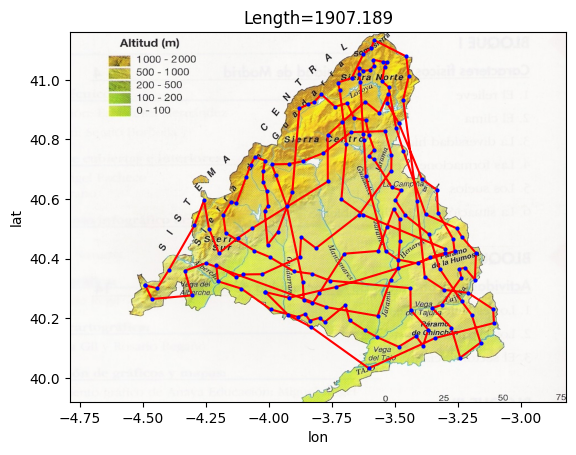

In [23]:
best_cords = list(map(lambda idx:cities[idx], best[0]))
draw(best_cords)

### Mutacion especifica para el problema:

In [56]:
class AG_perm_TSP(AG_perm):
    def __init__(self, alphabet, fitness_func, L, pcross, pmut, T):
        super().__init__(alphabet, fitness_func, L, pcross, pmut, T)
        

        

    def mutate (self, ind:list[int]): # la mutación consistirá en intercambiar elementos
        a, b = random.sample(range(self.L), 2)
        out = ind.copy()

        def swap():
            out[a], out[b] = out[b], out[a]
            return out

        def reverse():
            return (out[:a] + out[a:b+1:-1] + out[b+1:])
            
        if random.random() < self.pmut:
            if random.random() < 0.2:
                swap()
            else:
                reverse()

        return out

ag_cities_solver_reverse = AG_perm_TSP(list(range(len(cities))), cities_fitness, len(cities), 0.8, 0.2, 3)
pop = ag_cities_solver_reverse.create(N = 100)
best = ag_cities_solver_reverse.evolve(pop, trace=100, ngen=10_000, T=13, elitism=False)

GEN    1: distancia mejor -> 9803.58 km  (fitness=0.000102)
GEN  101: distancia mejor -> 5704.88 km  (fitness=0.000175)
GEN  201: distancia mejor -> 4785.52 km  (fitness=0.000209)
GEN  301: distancia mejor -> 4543.35 km  (fitness=0.000220)
GEN  401: distancia mejor -> 4240.02 km  (fitness=0.000236)
GEN  501: distancia mejor -> 4175.63 km  (fitness=0.000239)
GEN  601: distancia mejor -> 3977.80 km  (fitness=0.000251)
GEN  701: distancia mejor -> 3888.44 km  (fitness=0.000257)
GEN  801: distancia mejor -> 3806.84 km  (fitness=0.000263)
GEN  901: distancia mejor -> 3719.04 km  (fitness=0.000269)
GEN 1001: distancia mejor -> 3631.13 km  (fitness=0.000275)
GEN 1101: distancia mejor -> 3526.64 km  (fitness=0.000283)
GEN 1201: distancia mejor -> 3502.75 km  (fitness=0.000285)
GEN 1301: distancia mejor -> 3458.48 km  (fitness=0.000289)
GEN 1401: distancia mejor -> 3442.36 km  (fitness=0.000290)
GEN 1501: distancia mejor -> 3406.40 km  (fitness=0.000293)
GEN 1601: distancia mejor -> 3368.64 km 

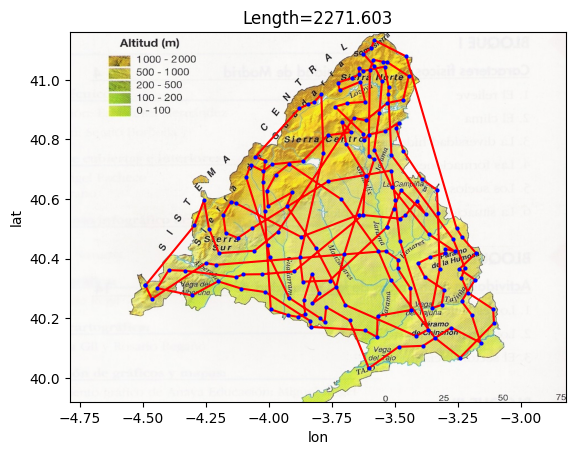

In [57]:
best_cords = list(map(lambda idx:cities[idx], best[0]))
draw(best_cords)

In [30]:
ag_cities_solver_reverse = AG_perm_TSP(list(range(len(cities))), cities_fitness, len(cities), 0.8, 0.2, 40)

UnboundLocalError: cannot access local variable 'out' where it is not associated with a value

In [ ]:
best_cords = list(map(lambda idx:cities[idx], best[0]))
draw(best_cords)

### Vamos con el TSP

Creamos la población

In [ ]:
def fitness_TSP (ind):
    return 1 / (1 + globaldist(ind))

g = AG_perm(cities, fitness_TSP, 0.7, 0.01, L=len(cities), T=2)
pop = g.create(cities)

TypeError: AG_perm.__init__() got multiple values for argument 'L'

### Evolucionamos y pintamos resultados

In [ ]:
pop = g.evolve(pop, ngen=1000, trace=100)
draw(pop[0])

Si no llega a una solución suficientemente buena. Puede ser por varios motivos:
  * Pocas generaciones. Continuar a ver.
  * pmut incorrecta: demasiado baja: convergencia muy lenta; demasiado alta: mucha aleatoriedad, la optimización no pregresa debido al ruido.
  * T incorrecto: demasiado bajo, pocas opciones a los mejores; demasiado alto: se cae en minimo local.
  * El mejor individuo se pierde: probar elitismo.
  * Hemos caído en un mínimo local: volver a empezar (multiarranque).
  * Hay otras estrategias de mutación mejores para este problema, mejorar la implementación.

1265.4403 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1257.1743 1257.1743 1257.1743 1247.5130 1247.5130 1247.2510 1247.2510 
Fitness óptimo: 1247.251
Mejor individuo [[40.54481, -3.457924], [40.53437, -3.481002], [40.50481, -3.53227], [40.54751, -3.626394], [40.54754, -3.642091], [40.42594, -3.565464], [40.42553, -3.536694], [40.39701, -3.487864], [40.4589, -3.479771], [40.48166, -3.364136], [40.54861, -3.377597], [40.59229, -3.41205], [40.6665, -3.392131], [40.63099, -3.332983], [40.5542, -3.328439], [40.50191, -3.254799], [40.47216, -3.233114], [40.46549, -3.268585], [40.43228, -3.298869], [40.36622, -3.321994], [40.33815, -3.380982], [40.38393, -3.409393], [40.40473, -3.360132], [40.41972, -3.298921], [40.42489, -3.262723], [40.41869, -3.177605], [40.3292, -3.181895], [40.36943, -3.221704], [40.36552, -3.243183], [40.33669, -3.235551], [40.29548, -3.303884], [40.23453, -3.352198], [40.24457, -3.314466], [40.

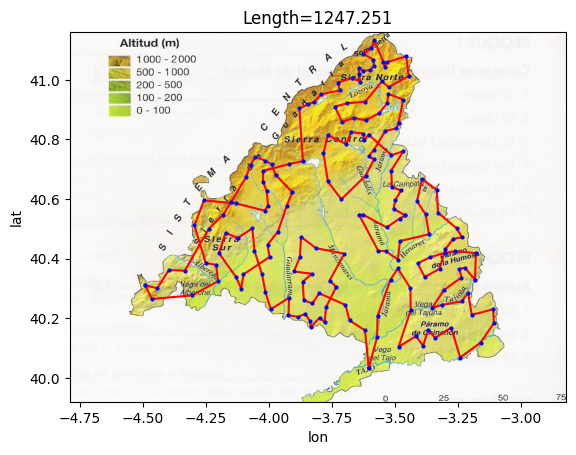

In [ ]:
# ejemplo; debes superar al menos esta solución:
pop = g.evolve(pop, ngen=10000, trace=500, T=12)
draw(pop[0])

In [ ]:
# función himmelblau y himmelblau global

onlyone = False # poner a True para que la solución sea única
def himmelblau (ch):
	x = ch[0]
	y = ch[1]
	fxy = (x**2 + y - 11)**2 + (x + y**2 -7)**2
	if onlyone and (x>0 or y>0): # himmelblau modified to have only one global minimum (-3.77, -3.28)
		fxy += 0.5
	return fxy

### Comentarios finales sobre el TSP

  * Hay varias vecindades interesantes en https://dm865.github.io/assets/dm865-tsp-ls-handout.pdf
  * Para problemas grandes, el problema es que como mínimo son $O(n^2)$
  * El fitness se puede calcular en una búsqueda local con deltas, es decir, alterando la evaluación anterior teniendo en cuenta el cambio realizado, lo que hace la evaluación mucho más rápida. Por ejemplo, si una ciudad se intercambia por otra sólo hay que restar 4 valores y sumar otros 4, en lugar de recorrer la lista entera.
  * Según el teorema del no free lunch, esto hace nuestro algoritmo más específico del problema TSP.